# Project Description
### Grape Leaf Classification

This project applies image processing and machine learning to classify leaf species from images. Key features extracted include color histograms, edges, and HOG patterns, which are used to train SVM and Decision Tree models. The effectiveness of each model is compared using accuracy metrics, and visualizations of the features provide interpretative insights into the classification process.

Dataset Link: https://www.kaggle.com/datasets/muratkokludataset/grapevine-leaves-image-dataset/data 

# Get The Data

In [1]:
import os
import zipfile

SAMPLE_SIZE_PER_CLASS = 100
IMAGE_DIMENSION = (128, 128)
IMAGE_DISPLAY_COUNT = 5
NUM_LABELS = 5
RANDOM_SEED = 48

dataset_file = "Grapevine_Leaves_Image_Dataset.zip"
data_top_folder = "Data"
dataset_folder = "Data/Grapevine_Leaves_Image_Dataset"

with zipfile.ZipFile(dataset_file, 'r') as zip_ref:
    zip_ref.extractall(data_top_folder)

# Checking the contents of the extracted dataset folder
extracted_files = os.listdir(dataset_folder)
extracted_files


['Ak',
 'Ala_Idris',
 'Buzgulu',
 'Dimnit',
 'Grapevine_Leaves_Image_Dataset_Citation_Request.txt',
 'Nazli']

# Visualize the Dataset

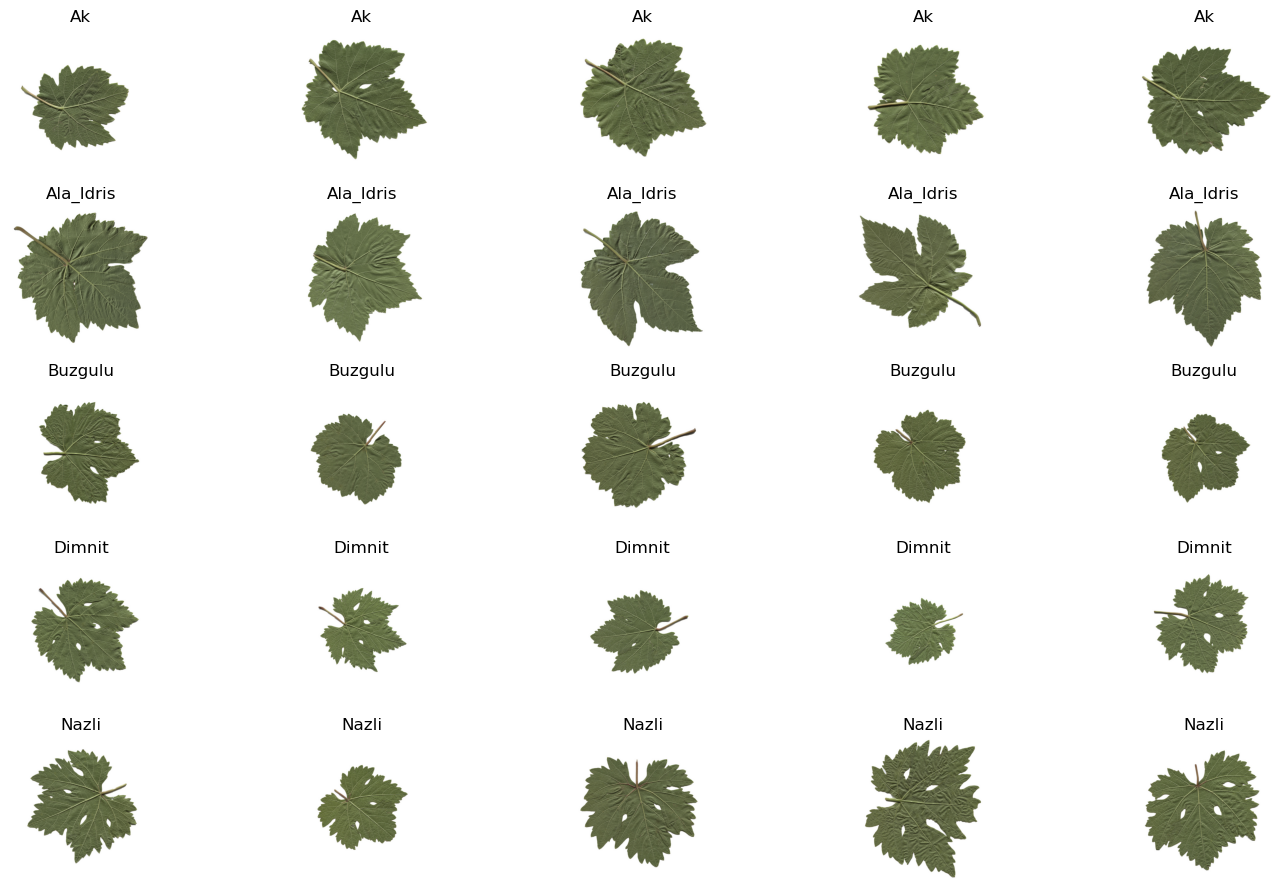

In [2]:
from pathlib import Path
import random
import matplotlib.pyplot as plt
import cv2


fig, axs = plt.subplots(5, IMAGE_DISPLAY_COUNT, figsize=(15, 9)) # 5 rows, x columns. rows are classes

# Counter for subplot position
subplot_counter = 0

for label_folder in os.listdir(dataset_folder):
    folder_path = Path(dataset_folder) / label_folder
    if folder_path.is_dir():
        image_files = [image_file for image_file in folder_path.iterdir() if image_file.is_file() and image_file.suffix == '.png']
        
        # Randomly select k files from the list
        selected_files = random.sample(image_files, k=IMAGE_DISPLAY_COUNT)
        
        for image_file in selected_files:
            if subplot_counter < IMAGE_DISPLAY_COUNT*5:
                img = cv2.imread(str(image_file))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Determine subplot position
                ax = axs[subplot_counter // IMAGE_DISPLAY_COUNT, subplot_counter % IMAGE_DISPLAY_COUNT]
                ax.imshow(img)
                ax.axis('off') 
                ax.set_title(label_folder)
                subplot_counter += 1

plt.tight_layout()
plt.show()

### Techniques for feature extraction:

c:\Users\dmaxw\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


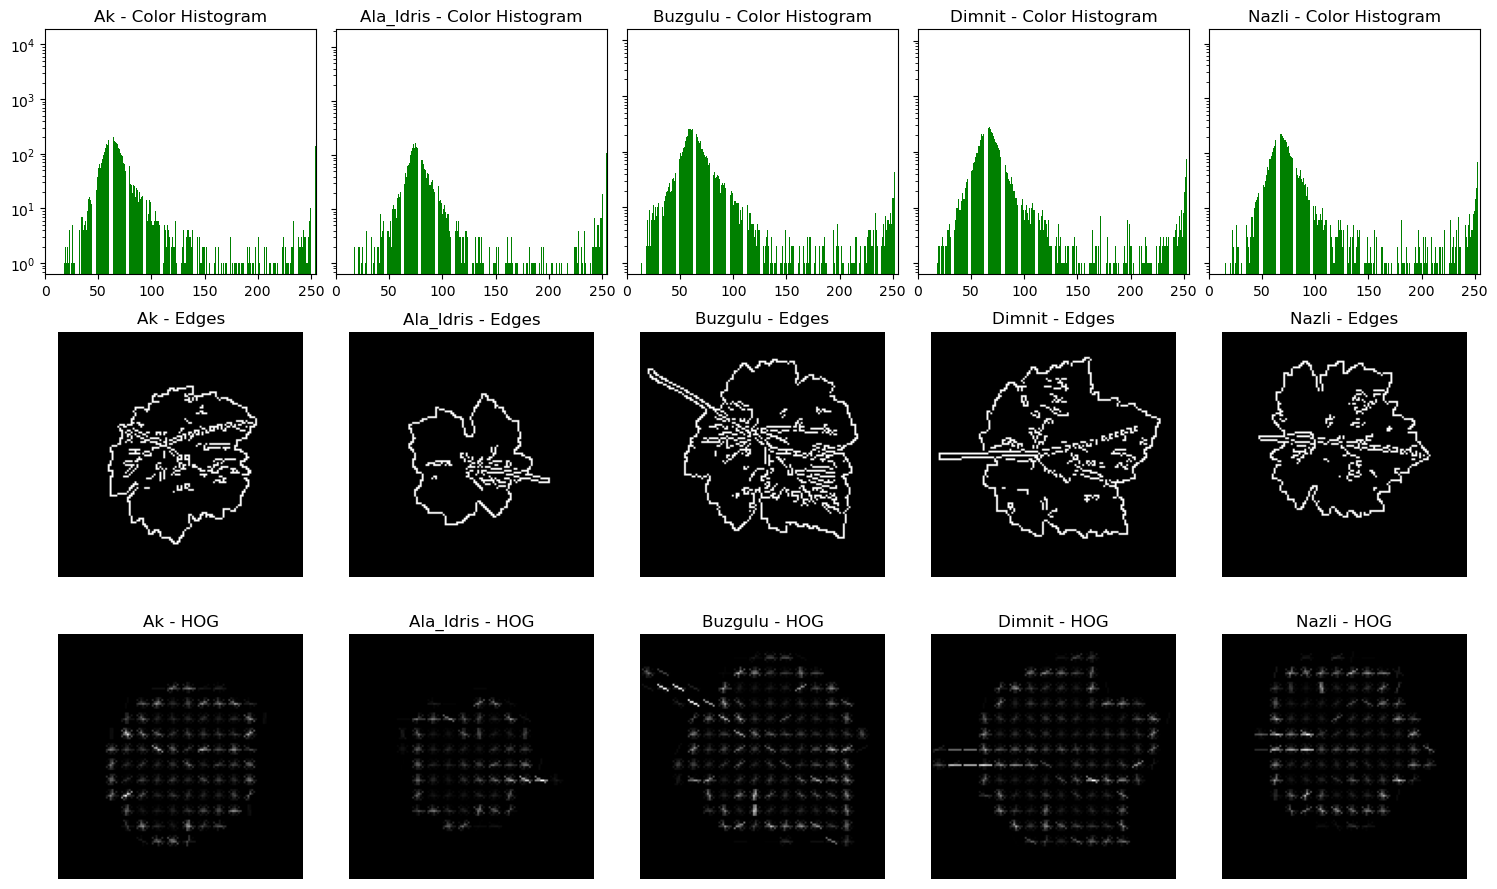

In [3]:
import random
import numpy as np
from pathlib import Path
from skimage.feature import hog
import cv2

# Showcase techniques for feature extraction
color_hist_examples = []
edge_examples = []
hog_examples = []
label_names = []

for label_folder in os.listdir(dataset_folder):
    folder_path = Path(dataset_folder) / label_folder
    if folder_path.is_dir():
        label_names.append(label_folder)

        image_files = [image_file for image_file in folder_path.iterdir() if image_file.is_file() and image_file.suffix == '.png']
        
        # Randomly select 1 files from the list
        selected_file = random.sample(image_files, k=1)

        img = cv2.imread(str(selected_file[0]))
        img = cv2.resize(img, IMAGE_DIMENSION)
        image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        color_hist = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()
        color_hist_examples.append(color_hist)
        
        # Edge detection features
        edges = cv2.Canny(image_gray, 100, 200).flatten()
        edge_examples.append(edges)

        # HOG detection features
        fd, hog_image = hog(image_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

        hog_examples.append(hog_image)        

fig, axs = plt.subplots(3, NUM_LABELS, figsize=(15, 9)) # 3 rows, num_classes columns

for i, label in enumerate(label_names):
    # Plot color histogram
    normalized_hist = color_hist_examples[i] / np.sum(color_hist_examples[i])
    axs[0, i].bar(range(256), color_hist_examples[i], color='green')
    axs[0, i].set_yscale('log') 
    axs[0, i].set_title(f'{label} - Color Histogram')
    axs[0, i].set_xlim([0, 255])
    if i > 0:
        axs[0, i].set_yticklabels([])

    # Plot edge detection result
    axs[1, i].imshow(edge_examples[i].reshape(image_gray.shape), cmap='gray')
    axs[1, i].set_title(f'{label} - Edges')
    axs[1, i].axis('off')

    # Plot corner detection result
    axs[2, i].imshow(hog_examples[i], cmap='gray') 
    axs[2, i].set_title(f'{label} - HOG')
    axs[2, i].axis('off')

plt.tight_layout()
plt.show()



# Preprocessing

In [4]:
import pandas as pd
import numpy as np
from skimage.feature import corner_harris, corner_peaks
from sklearn.preprocessing import StandardScaler

def extract_features(image_path, resize_dim=IMAGE_DIMENSION):
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, resize_dim)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Color histogram features (using the grayscale image)
    color_hist = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()

    # Edge detection features
    edges = cv2.Canny(image_gray, 100, 200).flatten()
    edge_hist = np.histogram(edges, bins=10)[0]

    # HOG detection features
    fd = hog(image_gray, orientations=8, pixels_per_cell=(16,16), cells_per_block=(1,1), block_norm='L2-Hys', visualize=False)

    """ print(f"Image path: {image_path}")
    print(f"Color hist shape: {color_hist.shape}")
    print(f"Edges shape: {edges.shape}")
    print("===========================================") """

    return np.concatenate([color_hist, edge_hist, fd])

data = []
labels = []
image_paths = []


for label_folder in os.listdir(dataset_folder):
    folder_path = Path(dataset_folder) / label_folder
    if folder_path.is_dir():
        # Get a list of all image files in the folder
        image_files = [image_file for image_file in folder_path.iterdir() if image_file.is_file() and image_file.suffix == '.png']
        
        # Randomly select k files from the list
        selected_files = random.sample(image_files, k=SAMPLE_SIZE_PER_CLASS)
        
        # Process each selected image file
        for image_file in selected_files:
            features = extract_features(str(image_file))
            data.append(features)
            labels.append(label_folder)
            image_paths.append(str(image_file))

features_df = pd.DataFrame(data)
features_df['image_path'] = image_paths
features_df['label'] = labels

numeric_features = features_df.drop([ 'image_path', 'label'], axis=1)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_features)

scaled_features_df = pd.DataFrame(scaled_features, columns=numeric_features.columns)
scaled_features_df['image_path'] = features_df['image_path']
scaled_features_df['label'] = features_df['label']

scaled_features_df.info()
scaled_features_df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 780 entries, 0 to label
dtypes: float64(778), object(2)
memory usage: 3.0+ MB


,0,1,2,3,4,5,6,7,8,9,...,768,769,770,771,772,773,774,775,776,777
count,500.0,500.0,500.0,500.0,500.0,500.0,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,...,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02
mean,0.0,0.0,0.0,0.0,0.0,0.0,7.105427e-18,-1.421085e-17,-3.907985e-17,5.684342e-17,...,1.421085e-17,3.197442e-17,7.105427e-18,-2.842171e-17,-2.842171e-17,1.421085e-17,1.421085e-17,7.105427e-18,7.105427e-18,-2.842171e-17
std,0.0,0.0,0.0,0.0,0.0,0.0,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,...,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00
min,0.0,0.0,0.0,0.0,0.0,0.0,-4.476615e-02,-1.049226e-01,-1.499830e-01,-2.075178e-01,...,-1.764093e-01,-1.652195e-01,-1.421590e-01,-1.264838e-01,-9.398050e-02,-1.283892e-01,-1.603409e-01,-1.486095e-01,-1.413949e-01,-1.391591e-01
25%,0.0,0.0,0.0,0.0,0.0,0.0,-4.476615e-02,-1.049226e-01,-1.499830e-01,-2.075178e-01,...,-1.764093e-01,-1.652195e-01,-1.421590e-01,-1.264838e-01,-9.398050e-02,-1.283892e-01,-1.603409e-01,-1.486095e-01,-1.413949e-01,-1.391591e-01
50%,0.0,0.0,0.0,0.0,0.0,0.0,-4.476615e-02,-1.049226e-01,-1.499830e-01,-2.075178e-01,...,-1.764093e-01,-1.652195e-01,-1.421590e-01,-1.264838e-01,-9.398050e-02,-1.283892e-01,-1.603409e-01,-1.486095e-01,-1.413949e-01,-1.391591e-01
75%,0.0,0.0,0.0,0.0,0.0,0.0,-4.476615e-02,-1.049226e-01,-1.499830e-01,-2.075178e-01,...,-1.764093e-01,-1.652195e-01,-1.421590e-01,-1.264838e-01,-9.398050e-02,-1.283892e-01,-1.603409e-01,-1.486095e-01,-1.413949e-01,-1.391591e-01
max,0.0,0.0,0.0,0.0,0.0,0.0,2.233831e+01,1.488403e+01,6.667424e+00,8.947678e+00,...,8.424546e+00,9.589933e+00,8.929039e+00,1.299437e+01,1.557942e+01,1.182353e+01,1.051276e+01,8.629718e+00,9.024327e+00,8.712542e+00


### Visualize Extracted Features

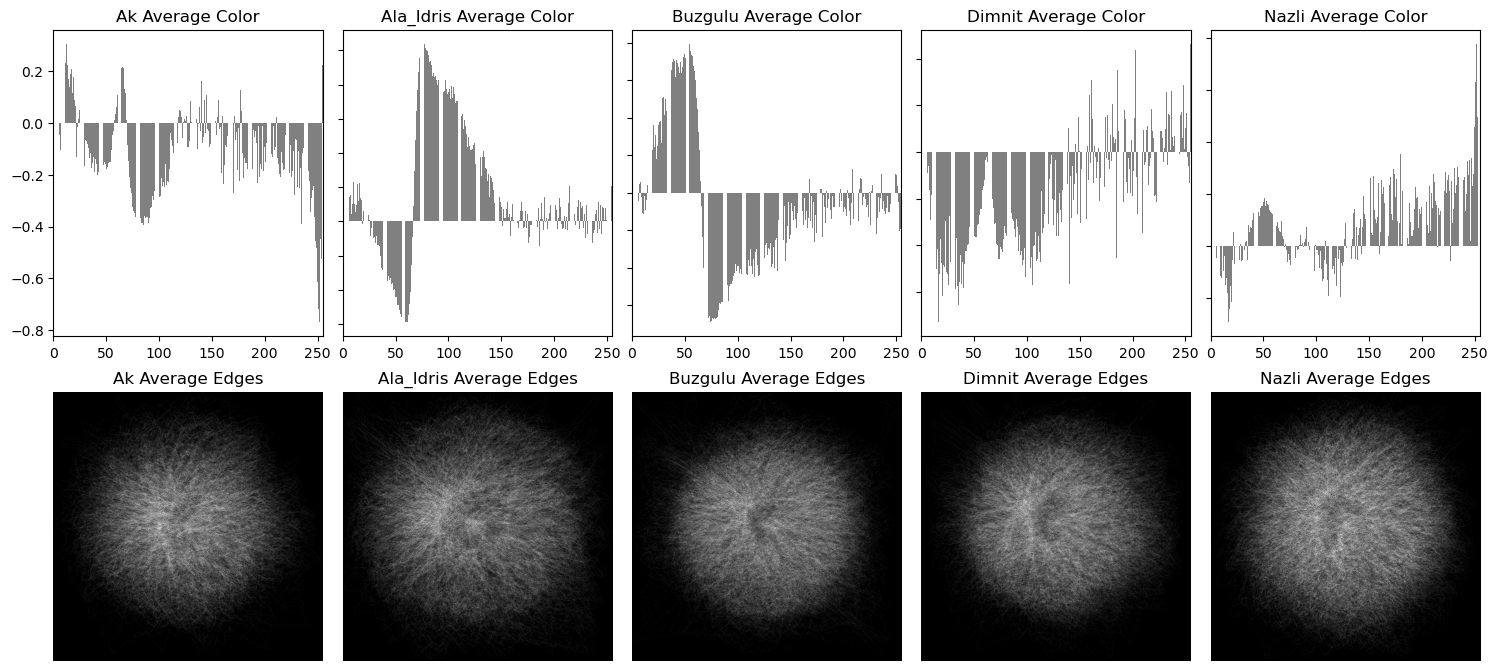

In [5]:
from matplotlib.gridspec import GridSpec

N = 256 

color_features = scaled_features_df.iloc[:, :N]
labels = scaled_features_df['label']

average_colors = color_features.groupby(labels).mean()

def compute_average_edge_image(image_paths):
    # Initialize an array to accumulate edge images
    sum_edges = None
    count = 0

    for image_path in image_paths:
        image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
        edges = cv2.Canny(image, 100, 200)

        if sum_edges is None:
            sum_edges = np.zeros_like(edges, dtype=np.float32)
        
        sum_edges += edges
        count += 1

    # Compute the average
    avg_edges = sum_edges / count
    return avg_edges

average_edge_images = {}

for label in average_colors.index:
    image_files = scaled_features_df[scaled_features_df['label'] == label]['image_path']
    average_edge_images[label] = compute_average_edge_image(image_files)


bins = 256

num_labels = average_colors.shape[0]

fig = plt.figure(figsize=(15, 7))

# Create a GridSpec layout
gs = GridSpec(2, num_labels, figure=fig)

# First row for Average Color
for i, label in enumerate(average_colors.index):
    ax = fig.add_subplot(gs[0, i])
    ax.bar(range(bins), average_colors.loc[label], color='gray')
    ax.set_title(label + ' Average Color')
    ax.set_xlim([0, bins - 1])
    if i > 0:
        ax.set_yticklabels([])

# Second row for Average Edges
for i, label in enumerate(average_edge_images):
    ax = fig.add_subplot(gs[1, i])
    ax.set_title(label + ' Average Edges')
    ax.imshow(average_edge_images[label], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Splitting the data

In [6]:
#Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

# Save image paths for later
train_image_paths = scaled_features_df['image_path']

X = scaled_features_df.drop(['label', 'image_path'], axis=1)
y = scaled_features_df['label'] 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X.head()



,0,1,2,3,4,5,6,7,8,9,...,768,769,770,771,772,773,774,775,776,777
0,0.0,0.0,0.0,0.0,0.0,0.0,-0.044766,-0.104923,-0.149983,-0.207518,...,-0.176409,-0.16522,-0.142159,-0.126484,-0.093981,-0.128389,-0.160341,-0.148609,-0.141395,-0.139159
1,0.0,0.0,0.0,0.0,0.0,0.0,-0.044766,-0.104923,-0.149983,-0.207518,...,0.544825,-0.16522,0.061295,-0.126484,-0.093981,4.996278,10.512765,0.167467,-0.141395,-0.139159
2,0.0,0.0,0.0,0.0,0.0,0.0,-0.044766,-0.104923,-0.149983,-0.207518,...,-0.176409,-0.16522,-0.142159,-0.126484,-0.093981,-0.128389,-0.160341,-0.148609,-0.141395,-0.139159
3,0.0,0.0,0.0,0.0,0.0,0.0,-0.044766,-0.104923,-0.149983,-0.207518,...,-0.176409,-0.16522,-0.142159,-0.126484,-0.093981,-0.128389,-0.160341,-0.148609,-0.141395,-0.139159
4,0.0,0.0,0.0,0.0,0.0,0.0,-0.044766,-0.104923,-0.149983,-0.207518,...,-0.176409,-0.16522,-0.142159,-0.126484,-0.093981,-0.128389,-0.160341,-0.148609,-0.141395,-0.139159


In [7]:
from sklearn.ensemble import RandomForestClassifier

# Train the model
rf_model = RandomForestClassifier(random_state=RANDOM_SEED)
rf_model.fit(X, y)

importances = rf_model.feature_importances_
feature_names = X.columns

# Combine importance scores and feature names
feature_importance = zip(feature_names, importances)
sorted_features = sorted(feature_importance, key=lambda x: x[1], reverse=True)

# Display feature importance
for feature, importance in sorted_features:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: 78, Importance: 0.012199671417524453
Feature: 80, Importance: 0.010643350052786733
Feature: 75, Importance: 0.01044169669530518
Feature: 252, Importance: 0.009764162930741963
Feature: 77, Importance: 0.009391208217269749
Feature: 251, Importance: 0.00907155039391859
Feature: 52, Importance: 0.008904329635515951
Feature: 49, Importance: 0.008901506920916173
Feature: 58, Importance: 0.008139792996405278
Feature: 54, Importance: 0.007931576746130606
Feature: 57, Importance: 0.007637993650395926
Feature: 56, Importance: 0.007420901390041054
Feature: 55, Importance: 0.007299671114329565
Feature: 72, Importance: 0.007216502755120795
Feature: 84, Importance: 0.007059901328948658
Feature: 81, Importance: 0.006882917852895446
Feature: 76, Importance: 0.0066992044556155005
Feature: 83, Importance: 0.006067546717488721
Feature: 79, Importance: 0.005977442105921489
Feature: 86, Importance: 0.005691883527644187
Feature: 73, Importance: 0.0056504160178766985
Feature: 50, Importance: 0.00536

# SVM with Kernel

In [8]:
from sklearn.svm import SVC

# Train a Support Vector Machine (SVM) classifier with a linear kernel
rbf_kernel = 'rbf'
svm_rbf_model = SVC(kernel=rbf_kernel)

svm_rbf_model.fit(X_train, y_train)


SVC()

# SVM without Kernel

In [9]:
svm_no_kernel_model = SVC(kernel='linear')

svm_no_kernel_model.fit(X_train, y_train)

SVC(kernel='linear')

# Decision Tree

In [10]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

dt_model = DecisionTreeClassifier(random_state=RANDOM_SEED)

dt_model.fit(X_train, y_train)


DecisionTreeClassifier(random_state=48)

### Decision Tree Visualization

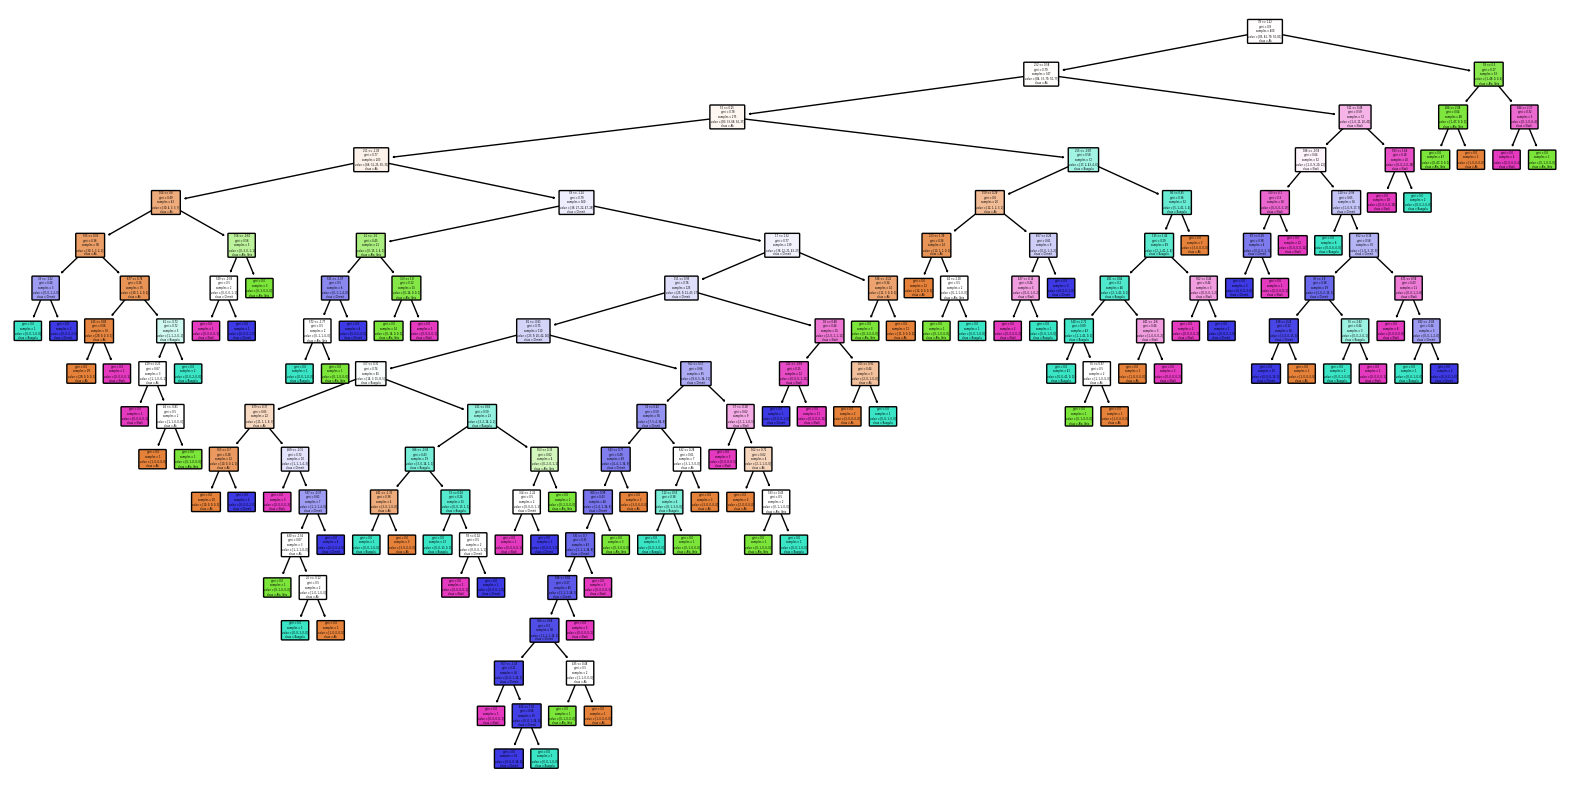

In [11]:
plt.figure(figsize=(20,10))
plot_tree(dt_model, filled=True, feature_names=X.columns.to_list(), class_names=list(dt_model.classes_), rounded=True, proportion=False, precision=2)
plt.show()


# Evaluation

In [12]:
from sklearn.metrics import classification_report

# Predict with each model
y_pred_rbf = svm_rbf_model.predict(X_test)
y_pred_linear = svm_no_kernel_model.predict(X_test)
y_pred_dt = dt_model.predict(X_test)

print("SVM with RBF Kernel:\n", classification_report(y_test, y_pred_rbf))
print("SVM with Linear Kernel:\n", classification_report(y_test, y_pred_linear))
print("Decision Tree:\n", classification_report(y_test, y_pred_dt))

SVM with RBF Kernel:
               precision    recall  f1-score   support

          Ak       0.45      0.67      0.54        15
   Ala_Idris       0.75      0.79      0.77        19
     Buzgulu       0.82      0.86      0.84        21
      Dimnit       0.82      0.54      0.65        26
       Nazli       0.68      0.68      0.68        19

    accuracy                           0.70       100
   macro avg       0.71      0.71      0.70       100
weighted avg       0.73      0.70      0.70       100

SVM with Linear Kernel:
               precision    recall  f1-score   support

          Ak       0.57      0.87      0.68        15
   Ala_Idris       0.82      0.74      0.78        19
     Buzgulu       0.79      0.90      0.84        21
      Dimnit       0.82      0.54      0.65        26
       Nazli       0.68      0.68      0.68        19

    accuracy                           0.73       100
   macro avg       0.74      0.75      0.73       100
weighted avg       0.75      0

In [13]:
from sklearn.model_selection import cross_val_score

# Cross-validation
cv_scores_rbf = cross_val_score(svm_rbf_model, X, y, cv=5)
cv_scores_linear = cross_val_score(svm_no_kernel_model, X, y, cv=5)
cv_scores_dt = cross_val_score(dt_model, X, y, cv=5)

print("Average CV Score - SVM RBF:", np.mean(cv_scores_rbf))
print("Average CV Score - SVM Linear:", np.mean(cv_scores_linear))
print("Average CV Score - Decision Tree:", np.mean(cv_scores_dt))

Average CV Score - SVM RBF: 0.6860000000000002
Average CV Score - SVM Linear: 0.6980000000000001
Average CV Score - Decision Tree: 0.42000000000000004
